# BERTScore

In [ ]:
!pip install bert_score

In [ ]:
import pandas as pd
import bert_score

# Load data from sheet in Google Drive
df = pd.read_csv("https://docs.google.com/spreadsheets/d/1balr63Uvw1N4jCVfx7wOXSB8BlzZl5Kw5Z_wkdoBK4w/export?format=csv")

# Extract original and paraphrased sentences
original_sentences = df['reference'].tolist()
paraphrased_sentences = df['t5_0'].tolist() # Select the model

In [ ]:
# Compute BERTScore for each pair of original and paraphrased sentences
P, R, F1 = bert_score.score(original_sentences, paraphrased_sentences, lang="en", model_type='microsoft/deberta-xlarge-mnli', rescale_with_baseline=False, verbose=True) 

Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/269 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/157 [00:00<?, ?it/s]

done in 218.39 seconds, 45.79 sentences/sec


In [ ]:
P_list = [round(num, 4) for num in P.tolist()]
R_list = [round(num, 4) for num in R.tolist()]
F1_list = [round(num, 4) for num in F1.tolist()]

for i, val in enumerate(F1_list):
  df.loc[i, "bertscore_p"] = P_list[i]
  df.loc[i, "bertscore_r"] = R_list[i]
  df.loc[i, "bertscore_f1"] = F1_list[i]

In [ ]:
# Extract the desired columns into a new dataframe
df_selected = df[['id', 'reference', 't5_0', 'bertscore_p', 'bertscore_r', 'bertscore_f1', 'bertscore_p_rescale', 'bertscore_r_rescale', 'bertscore_f1_rescale']]

# Export the selected columns to a CSV file
df_selected.to_csv('t5_bertscore_deberta-xlarge-mnli.csv', index=False)

from google.colab import files
files.download('t5_bertscore_deberta-xlarge-mnli.csv')

In [ ]:
import matplotlib.pyplot as plt

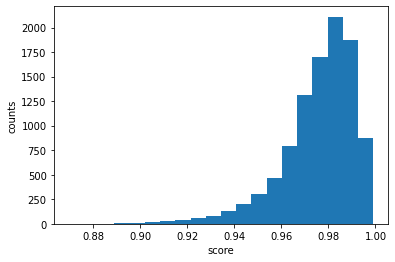

In [ ]:
# without rescale roberta-large
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

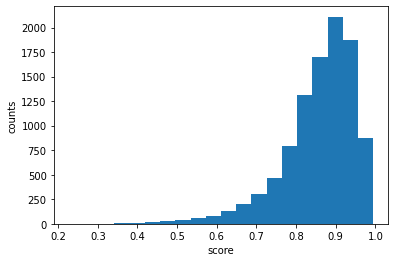

In [ ]:
# with rescale roberta-large
plt.hist(F1s, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

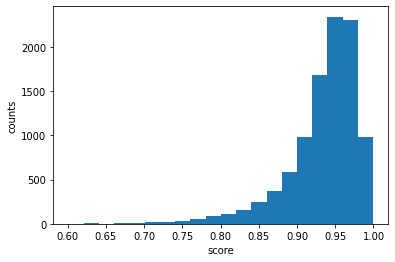

In [ ]:
# without rescale deberta-xlarge-mnli
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

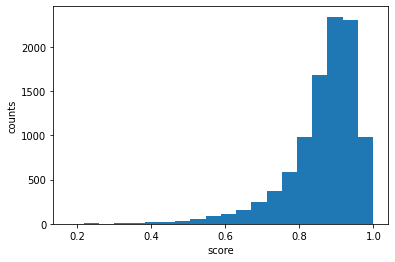

In [ ]:
# with rescale deberta-xlarge-mnli_rescale
plt.hist(F1s, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

# STSB and CoLA with T5

In [ ]:
!pip3 install torch
!pip3 install transformers
!pip install sentencepiece

In [ ]:
from transformers import T5ForConditionalGeneration,T5Tokenizer
import torch
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

df = pd.read_csv("https://docs.google.com/spreadsheets/d/1balr63Uvw1N4jCVfx7wOXSB8BlzZl5Kw5Z_wkdoBK4w/export?format=csv")

In [ ]:
device = "cuda:0"
model = model.to(device)

In [ ]:
def similarity(x):
    input_ids = tokenizer.encode(str(x), return_tensors='pt', max_length=512)
    input_ids = input_ids.to(device)
    outputs = model.generate(input_ids=input_ids)
    similarityd = tokenizer.decode(outputs[0])
    return similarityd
def cola(y):
    input_ids = tokenizer.encode(str(y), return_tensors='pt')
    input_ids = input_ids.to(device)
    outputs = model.generate(input_ids=input_ids)
    colad = tokenizer.decode(outputs[0])
    return colad

In [ ]:
# change for every column (reference, chatgpt, gpt3, t5)
df["cola_sen"] = 'cola sentence: ' + df['t5_0'] + ' '

for i, ref in df['Cola_Prep'].items():
  df.at[i, 'cola_t5'] = cola(ref)

In [ ]:
# Extract the desired columns into a new dataframe
df_selected = df[['id', 'cola_reference', 'cola_chatgpt', 'cola_gpt3', 'cola_t5']]

# Export the selected columns to a CSV file
df_selected.to_csv('cola.csv', index=False)

from google.colab import files
files.download('cola.csv')

In [ ]:
import re

for i, ref in df["reference"].items():
  sentence_1 = ref
  sentence_2 = df.loc[i, 't5_0']
  similarity_check = f"stsb sentence1:{sentence_1} sentence2:{sentence_2}"

  similarity_values = similarity(similarity_check)

  match = re.findall(r'\d+\.\d+', similarity_values)
  number = float(match[0]) if match else None

  df.loc[i, 'stsb'] = number

In [ ]:
# Extract the desired columns into a new dataframe
df_selected = df[['id', 'reference', 't5_0', 'stsb']]

# Export the selected columns to a CSV file
df_selected.to_csv('t5_stsb_scores.csv', index=False)

from google.colab import files
files.download('t5_stsb_scores.csv')

# ROUGE

In [ ]:
!pip install evaluate
!pip install rouge_score

In [ ]:
import evaluate
import pandas as pd

# Load data from sheet in Google Drive
df = pd.read_csv("https://docs.google.com/spreadsheets/d/1balr63Uvw1N4jCVfx7wOXSB8BlzZl5Kw5Z_wkdoBK4w/export?format=csv")

In [ ]:
rouge = evaluate.load("rouge")

for i, ref in df["reference"].items():
  references = [ref]
  predictions = [df.at[i, 'gpt3']]

  score = rouge.compute(predictions=predictions, references=references)

  df.loc[i, 'rouge1'] = round(score['rouge1'], 4)
  df.loc[i, 'rouge2'] = round(score['rouge2'], 4)
  df.loc[i, 'rougeL'] = round(score['rougeL'], 4)

In [ ]:
# Extract the desired columns into a new dataframe
df_selected = df[['id', 'reference', 't5_0', 'rouge1-p', 'rouge1-r', 'rouge1-f', 'rouge2-p', 'rouge2-r', 'rouge2-f', 'rougeL-p', 'rougeL-r', 'rougeL-f']]

# Export the selected columns to a CSV file
df_selected.to_csv('t5_rouge_scores.csv', index=False)

from google.colab import files
files.download('t5_rouge_scores.csv')

# BLEU

In [ ]:
bleu = evaluate.load("bleu")

for i, ref in df["reference"].items():
  references = ref
  predictions = df.loc[i, 't5_0']

  result = bleu.compute(predictions=[predictions], references=[references])

  df.loc[i, 'bleu'] = round(result['bleu'], 4)
  df.loc[i, 'brevity_penalty'] = round(result['brevity_penalty'], 4)

In [ ]:
# Extract the desired columns into a new dataframe
df_selected = df[['id', 'reference', 't5_0', 'bleu', 'brevity_penalty']]

# Export the selected columns to a CSV file
df_selected.to_csv('t5_bleu_scores.csv', index=False)

from google.colab import files
files.download('t5_bleu_scores.csv')

In [ ]:
df['bleu'].mean()

0.54916047

# GLEU

In [ ]:
google_bleu = evaluate.load("google_bleu")

for i, ref in df["reference"].items():
  references = ref
  predictions = df.loc[i, 't5_0']

  result = google_bleu.compute(predictions=[predictions], references=[[references]])

  df.loc[i, 'google_bleu'] = round(result['google_bleu'], 4)

In [ ]:
# Extract the desired columns into a new dataframe
df_selected = df[['id', 'reference', 't5_0', 'google_bleu']]

# Export the selected columns to a CSV file
df_selected.to_csv('t5_gleu_scores.csv', index=False)

from google.colab import files
files.download('t5_gleu_scores.csv')

In [ ]:
df['google_bleu'].mean()

0.5892087300000001

# METEOR

In [ ]:
meteor = evaluate.load("meteor")

for i, ref in df["reference"].items():
  references = ref
  predictions = df.loc[i, 't5_0']

  result = meteor.compute(predictions=[predictions], references=[references])

  df.loc[i, 'meteor'] = round(result['meteor'], 4)

In [ ]:
# Extract the desired columns into a new dataframe
df_selected = df[['id', 'reference', 't5_0', 'meteor']]

# Export the selected columns to a CSV file
df_selected.to_csv('t5_meteor_scores.csv', index=False)

from google.colab import files
files.download('t5_meteor_scores.csv')

In [ ]:
df['meteor'].mean()

0.8011389999999999